# Imports

In [3]:
import shapely
import sys
import re
from importlib import reload
from pathlib import Path
import plotly.graph_objects as go
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px
from tqdm.auto import tqdm
from skimpy import skim, clean_columns

tqdm.pandas()
import pickle
import global_land_mask as glm
from geopy.distance import great_circle

# Utilitaires & globaux
sys.path.insert(0, (Path().cwd().parent / "0_utilitaires_et_globaux").__str__())
# noinspection PyUnresolvedReferences
import classe_routes as cr
# noinspection PyUnresolvedReferences
import fonctions_utilitaires_donnees as fud
# noinspection PyUnresolvedReferences
import classe_routes as cr
# noinspection PyUnresolvedReferences
import parametres_globaux as pg

reload(cr)
reload(fud)
reload(pg)

print('Imports : ok')


PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.
Imports : ok


# Extraction des données de routes

## Extraction des zones

In [ ]:
zones_dnv = pd.read_excel('dnv_zones.xlsx', index_col=0, header=0, sheet_name='Feuil5')
zones_dnv.index = zones_dnv.index.astype(str)

# Mapping string ref
for i in range(3):
    for idx in tqdm(zones_dnv.index):
        for col in zones_dnv.columns:
            value = zones_dnv.loc[idx, col]
            if "_" in str(value):
                zones_dnv.loc[idx, col] = zones_dnv.loc[value.split('_')[0], value.split('_')[1]]
            else:
                zones_dnv.loc[idx, col] = float(value)

ax = 2/(zones_dnv.loc['total', 'x2'] - zones_dnv.loc['total', 'x1'])*180
ay = 2/(zones_dnv.loc['total', 'y2'] - zones_dnv.loc['total', 'y1'])*90
bx= -(zones_dnv.loc['total', 'x2'] + zones_dnv.loc['total', 'x1'])/2*ax
by= -(zones_dnv.loc['total', 'y2'] + zones_dnv.loc['total', 'y1'])/2*ay
print(ax, ay, bx, by)
zones_dnv["x1"] = zones_dnv['x1']*ax + bx
zones_dnv["x2"] = zones_dnv['x2']*ax+bx
zones_dnv["y1"] = zones_dnv["y1"]*ay+by
zones_dnv["y2"] = zones_dnv["y2"]*ay+by
zones_dnv = zones_dnv.sort_values(by = ['x1', "y1"])
skim(zones_dnv)
zones_dnv['polygone'] = zones_dnv.apply(lambda row: shapely.Polygon([(row.x1, row.y1), (row.x1, row.y2), (row.x2, row.y2), (row.x2, row.y1)]), axis=1)
zones_dnv.to_pickle('zones_dnv_shapes.pkl')

In [ ]:
figtest = go.Figure(
    data=[
        go.Scattermapbox(
            lat=np.array(polygone.exterior.xy[1]),
            lon=np.array(polygone.exterior.xy[0]),
            mode="lines",
            line=dict(width=1, color='darkgrey'),
            showlegend=False,
            name = zones_dnv.index[idx]

        )
        for idx, polygone in enumerate(zones_dnv.polygone)
    ]
)
figtest.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox=go.layout.Mapbox(
        style="open-street-map",
        zoom=1,
        center_lat=0,
        center_lon=0,
    ),
    hovermode='x unified'
)
figtest.write_html('test_boites_mer.html')

## Extraction des coordonnées des ports

### Extraction des ports + remapping + coord

In [ ]:
# Getting all ports
reload(cr)

liste_port_calls = Path(Path().cwd() / "Port Calls").glob("*.xlsx")
noms_port_calls = pd.Series([
    modele for modele in liste_port_calls if not re.search(r"^(~\$).*", modele.__str__().split("\\")[-1])
])

print('Reading Files')
port_calls_all = []
for chem in tqdm(noms_port_calls):
    port_calls_all += [pd.read_excel(chem, usecols='A, C')]

raw_port_calls = clean_columns(pd.concat(port_calls_all, axis=0).drop_duplicates(), case='camel').sort_values(by=['countryTerritory', 'port'])

In [ ]:
# Cleaning Port Calls
port_calls_final = cr.get_clean_port_names(raw_port_calls)
display(port_calls_final)

print('Récupération des coordonnées')
port_calls_clean = port_calls_final[['port_clean', 'countryTerritory']].drop_duplicates()

# Getting Locations
geolocator = Nominatim(user_agent="app_ports")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

try:
    with open('all_ports_locations.pkl', "rb") as f:
        former_port_calls_clean = pickle.load(f)[['port_clean', 'countryTerritory', 'long_lat']]
        former_port_calls_clean = former_port_calls_clean.drop_duplicates(subset = ['port_clean', 'countryTerritory'])
except FileNotFoundError:
    former_port_calls_clean = pd.DataFrame(columns=['port_clean', 'countryTerritory', 'long_lat'])

port_calls_clean = port_calls_clean.merge(former_port_calls_clean, on = ['port_clean', 'countryTerritory'], how='left')
print(f'Nombre de ports à localiser : {port_calls_clean["long_lat"].isnull().sum()}')
port_calls_clean['long_lat'] = port_calls_clean.progress_apply(
    lambda row: geocode(
        f'{row.port_clean + ", " if str(row.port_clean).lower() != "nan" else ""}{row.countryTerritory}'
    ) if pd.isnull(row['long_lat']) else row['long_lat'], axis=1
)

port_calls_final = port_calls_final.merge(port_calls_clean, on = ['port_clean', 'countryTerritory'])

In [ ]:
port_calls_final[port_calls_final.long_lat.isnull()].drop_duplicates(subset='port')

### Affichage

In [ ]:
fig = go.Figure(
    data=[
        go.Scattermapbox(
            lat=port_calls_final[~port_calls_final.long_lat.isnull()].long_lat.apply(lambda geo: geo.latitude),
            lon=port_calls_final[~port_calls_final.long_lat.isnull()].long_lat.apply(lambda geo: geo.longitude),
            mode="markers",
            # line=dict(width=2, color="navy"),
            hovertemplate="<b>Port: %{customdata}</b><br>lat:%{lat:.3f}°<br>lon:%{lon:.3f}°",
            customdata=port_calls_final[~port_calls_final.long_lat.isnull()].port
        ),
    ]
)

fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox=go.layout.Mapbox(
        style="open-street-map",
        zoom=1.5,
        center_lat=0,
        center_lon=0,
    ),
    hovermode='x unified'
)


fig.write_html("Localisation_ports.html")
fig.show()

### Sauvegarde

In [ ]:
port_calls_final.to_pickle('all_ports_locations.pkl')

## Création des Routes

### Obtention des paramètres préalablement calculés

In [4]:
nom_zones = 'zones_dnv_shapes.pkl'
zones_dnv = pickle.load(open(nom_zones, "rb"))
zones_dnv = zones_dnv[zones_dnv.index != 'total']
zones_dnv

,x1,x2,y1,y2,polygone
zone,,,,,
102,-180.0,-150.530973,-50.176991,-40.619469,"POLYGON ((-180 -50.176991150442475, -180 -40.6..."
86,-180.0,-120.265487,-40.619469,-30.265487,"POLYGON ((-180 -40.61946902654867, -180 -30.26..."
81,-180.0,-144.955752,-30.265487,-20.707965,"POLYGON ((-180 -30.26548672566372, -180 -20.70..."
72,-180.0,-129.823009,-20.707965,-10.353982,"POLYGON ((-180 -20.707964601769916, -180 -10.3..."
71G,-180.0,-176.017699,-10.353982,10.353982,"POLYGON ((-180 -10.353982300884951, -180 10.35..."
...,...,...,...,...,...
20,150.530973,180.0,39.823009,50.176991,POLYGON ((150.53097345132744 39.82300884955754...
80,156.902655,180.0,-30.265487,-10.353982,POLYGON ((156.90265486725662 -30.2654867256637...
12D,160.088496,180.0,224.60177,54.955752,POLYGON ((160.08849557522126 224.6017699115044...


In [5]:
nom_locations = 'all_ports_locations.pkl'
df_geocodes = pickle.load(open(nom_locations, "rb"))
df_geocodes.rename(columns = {'long_lat': 'geocode'}, inplace=True)

fig = go.Figure(
)

colors = px.colors.sample_colorscale('Blues', samplepoints=len(df_geocodes.countryTerritory.unique()), low=0.3)
colors = {country: colors[i] for i, country in enumerate(df_geocodes.countryTerritory.unique())}


fig.add_traces(data=[
        go.Scattermapbox(
            lat=np.array([df_geocodes.loc[idx, 'geocode'].latitude]),
            lon=np.array([df_geocodes.loc[idx, 'geocode'].longitude]),
            mode="markers",
            marker=dict(color=colors[df_geocodes.loc[idx, 'countryTerritory']]),
            # line=dict(width=2, color="navy"),
            hovertemplate="<b>Port: %{customdata}</b><br>lat:%{lat:.3f}°<br>lon:%{lon:.3f}°",
            customdata=np.array([df_geocodes.loc[idx, 'port']]),
            legendgroup = df_geocodes.loc[idx, 'countryTerritory'],
            legendgrouptitle_text = df_geocodes.loc[idx, 'countryTerritory'],
            name = df_geocodes.loc[idx, 'port']
        )
        for idx in df_geocodes[~df_geocodes.geocode.isnull()].index.to_list()
    ]
)

fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox=go.layout.Mapbox(
        style="open-street-map",
        zoom=1.5,
        center_lat=0,
        center_lon=0,
    ),
    hovermode='x unified'
)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.write_html("Localisation_ports.html")

df_geocodes

,port,countryTerritory,port_clean,geocode
0,Algiers,Algeria,Algiers,"(Alger ⴷⵣⴰⵢⴻⵔ الجزائر, Alger Centre ⴷⵣⴰⵢⴻⵔ ⵜⴰⵍ..."
1,Annaba,Algeria,Annaba,"(Annaba ⵄⴻⵍⵍⴰⴲⴰ عنابة, Daïra Annaba دائرة عناب..."
2,Arzew,Algeria,Arzew,"(Arzew ⴰⵔⴻⵣⵢⵓ أرزيو, Daïra Arzew, Oran ⵡⴻⵀⵔⴰⵏ ..."
3,Arzew El-Djedid,Algeria,Arzew,"(Arzew ⴰⵔⴻⵣⵢⵓ أرزيو, Daïra Arzew, Oran ⵡⴻⵀⵔⴰⵏ ..."
4,Mostaganem,Algeria,Mostaganem,"(Mostaganem ⵎⵓⵙⵜⵖⴰⵏⴻⵎ مستغانم, Algérie / ⵍⵣⵣⴰⵢ..."
...,...,...,...,...
532,FPSO 'Dai Hung 01',Vietnam,Vung Tau,"(Thành phố Vũng Tàu, Tỉnh Bà Rịa - Vũng Tàu, V..."
533,Vung Tau,Vietnam,Vung Tau,"(Thành phố Vũng Tàu, Tỉnh Bà Rịa - Vũng Tàu, V..."
534,Laayoune,Maroc,Laayoune,"(Laâyoune العيون, Pachalik de Laâyoune باشوية ..."
535,Balhaf LNG,Yemen,Balhaf,"(بلحاف, مديرية رضوم, محافظة شبوة, اليمن, (14.0..."


In [6]:
zones_dnv_limits = pd.DataFrame(
    [poly.bounds for poly in zones_dnv.polygone],
    columns=['long_min', 'lat_min', 'long_max', 'lat_max'],
    index=zones_dnv.index
).to_dict(orient='index')

### Obtention de tous les trajets

In [10]:
# %%capture --no-stderr
reload(cr)
reload(fud)
path = Path().cwd() / 'Port Calls'
print('Getting Port Calls')
files = fud.get_all_port_calls()
print('Getting Journeys')
# pd.options.mode.chained_assignment = None  # default='warn'
df_all_files = cr.retrieve_all_journeys_multiple_boats(path, files, prints=False)

Getting Port Calls
Getting Journeys


  0%|          | 0/208 [00:00<?, ?it/s]

In [11]:
skim(df_all_files)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 59773  │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 12     │ │ datetime64  │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA      ┃ NA %    ┃ mean    ┃ sd    ┃ p0   ┃ p25   ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ departureDraught         │    8900 │      15 │      10 │   1.6 │    0 │   9.3 │    11 │      26 │     █    │  │
│ │ arrivalDraught           │    8800 │      15 │      10 │   1.6 │    0 │   9.3 │    11 │      26 │     █    │  │
│ └──────────────────────────┴─────────┴─────────┴─────────┴───────┴──────┴───────┴───────┴─────────┴──────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %   ┃ first                      ┃ last                      ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ departureDate      │    0 │      0 │    2009-07-12 00:56:33     │    2023-04-29 15:30:13    │ None         │  │
│ │ arrivalDate        │    0 │      0 │    2009-07-15 14:59:58     │    2023-05-02 11:04:06    │ None         │  │
│ └────────────────────┴──────┴────────┴────────────────────────────┴───────────────────────────┴──────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Navire                             │      0 │         0 │                         3 │               180000 │  │
│ │ port                               │      0 │         0 │                         3 │               180000 │  │
│ │ port_clean                         │     12 │      0.02 │                         3 │               180000 │  │
│ │ countryTerritory                   │      0 │         0 │                         3 │               180000 │  │
│ │ callingType                        │      0 │         0 │                         3 │               180000 │  │
│ │ destination                        │      0 │         0 │                         3 │               180000 │  │
│ │ clean_destination                  │     12 │      0.02 │                         3 │               180000 │  │
│ │ destinationCountry                 │      0 │       

### Obtention de toutes les routes

In [12]:
reload(cr)
# dests = cr.get_routes_from_loc_file(df_all_files.iloc[:, :], df_geocodes, zones_dnv.polygone, zones_dnv_limits, 'Routes')
dests = cr.get_routes_from_loc_file(df_all_files.iloc[:, :], df_geocodes, zones_dnv.polygone, zones_dnv_limits, 'Routes', completion=True)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 537    │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 3      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA     ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ port                             │      0 │         0 │                        1.8 │                   940 │  │
│ │ port_clean                       │      1 │      0.19 │                        1.8 │                   940 │  │
│ │ countryTerritory                 │      0 │         0 │                        1.8 │                   940 │  │
│ └──────────────────────────────────┴────────┴───────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Nombre de localisations non extraites : 0, remplacement par le centre du pays
Empty DataFrame
Columns: [port, port_clean, countryTerritory, geocode]
Index: []
Index(['Navire', 'port', 'port_clean', 'countryTerritory', 'departureDate',
       'departureDraught', 'callingType', 'destination', 'clean_destination',
       'destinationCountry', 'arrivalDate', 'arrivalDraught'],
      dtype='object')
--------------------------------------------------
Creating Routes
--------------------------------------------------
Calcul des routes et des distances par zone traversée par route
Trajectoires non répertoriées :  Empty DataFrame
Columns: [port_clean, port_clean_destination]
Index: []
Recherche de routes existantes dans Routes
Nombre de routes existantes trouvées : 7825 (100.0%)


100%|██████████| 7822/7822 [00:14<00:00, 528.18it/s]


Agrégation


In [14]:
dests["points"] = dests['routes'].progress_apply(lambda x : np.array([x.get_lont_lat_point(idx).to_numpy() for idx in x.points_non_reconnus]))
dests["len_points"] = dests['routes'].progress_apply(lambda x : len(x.points_non_reconnus))

100%|██████████| 59816/59816 [00:00<00:00, 724270.24it/s]


In [16]:
fig = go.Figure()
points_absents = np.concatenate(dests[dests.len_points > 2].drop_duplicates(['port', 'destination', 'countryTerritory', 'destinationCountry']).points.to_list(),axis=0)
fig.add_trace(go.Scattermapbox(
    lat = points_absents[:, 1],
    lon = points_absents[:, 0]
    )
)
fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox=go.layout.Mapbox(
        style="open-street-map",
        zoom=0.75,
        center_lat=0,
        center_lon=0,
    )
)
fig.write_html('points_manquants.html')
fig.show()

In [17]:
dests.to_pickle('allTravels.pkl')

# Tracé des trajets d'un navire

In [2]:
with open('allTravels.pkl', 'rb') as f:
    all_travels = pickle.load(f)

In [3]:
all_travels.insert(1, 'nomNavire', all_travels.Navire.apply(
    lambda nav : nav.__str__().split('\\')[-1]
))
all_travels

,Navire,nomNavire,port,port_clean,countryTerritory,departureDate,departureDraught,callingType,destination,clean_destination,destinationCountry,arrivalDate,arrivalDraught,port_clean_destination,trajectoire,routes,points,len_points
40,C:\Users\TRS\Documents\sbtt_first_databases\1_...,AAMIRA,Incheon Tanker Terminal,Incheon,Korea,2010-04-16 01:59:58,NaN,Anchorage,Singapore Sudong Bunkering Anchorage,Singapore,Singapore,2010-06-08 12:59:00,NaN,Singapore,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Incheon -> Singapore)",[],0
204,C:\Users\TRS\Documents\sbtt_first_databases\1_...,AAMIRA,Singapore Sudong Bunkering Anchorage,Singapore,Singapore,2010-06-09 00:59:55,NaN,Anchorage,Fujairah Anchorage,Fujairah,United Arab Emirates,2010-07-02 06:58:22,NaN,Fujairah,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Singapore -> Fujairah)",[],0
6080,C:\Users\TRS\Documents\sbtt_first_databases\1_...,AAMIRA,Fujairah Anchorage,Fujairah,United Arab Emirates,2010-07-07 06:57:20,NaN,Anchorage,Ras Laffan,Ras Laffan,Qatar,2010-07-18 03:56:30,NaN,Ras Laffan,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Fujairah -> Ras Laffan)",[],0
2278,C:\Users\TRS\Documents\sbtt_first_databases\1_...,AAMIRA,Ras Laffan,Ras Laffan,Qatar,2010-07-20 15:59:23,NaN,Port,Suez Canal,Suez,Egypt,2010-07-29 06:59:52,NaN,Suez,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Ras Laffan -> Suez)",[],0
6473,C:\Users\TRS\Documents\sbtt_first_databases\1_...,AAMIRA,Suez Canal,Suez,Egypt,2010-07-29 06:59:52,NaN,Port,Milford Haven,Milford Haven,United Kingdom,2010-08-10 04:00:02,NaN,Milford Haven,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Suez -> Milford Haven)",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11758,C:\Users\TRS\Documents\sbtt_first_databases\1_...,ZARGA,Ras Laffan,Ras Laffan,Qatar,2023-02-07 13:19:29,9.4,Terminal,Incheon,Incheon,South Korea,2023-02-24 00:50:34,11.8,Incheon,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Ras Laffan -> Incheon)",[],0
12004,C:\Users\TRS\Documents\sbtt_first_databases\1_...,ZARGA,Incheon,Incheon,South Korea,2023-02-25 07:23:16,11.8,Terminal,Singapore,Singapore,Singapore,2023-03-04 23:48:26,11.8,Singapore,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Incheon -> Singapore)",[],0
10115,C:\Users\TRS\Documents\sbtt_first_databases\1_...,ZARGA,Singapore,Singapore,Singapore,2023-03-05 00:03:21,11.8,Anchorage,Ras Laffan,Ras Laffan,Qatar,2023-03-21 11:03:07,12.0,Ras Laffan,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Singapore -> Ras Laffan)",[],0
958,C:\Users\TRS\Documents\sbtt_first_databases\1_...,ZARGA,Ras Laffan,Ras Laffan,Qatar,2023-03-22 22:42:57,12.0,Terminal,Suez Canal,Suez,Egypt,2023-03-30 11:32:32,12.0,Suez,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Ras Laffan -> Suez)",[],0


In [8]:
navire = "YENISEI RIVER"
date_min = pd.to_datetime('2018-08-01')
date_max = pd.to_datetime('2024-08-01')
voyages_navire = all_travels[all_travels.nomNavire==navire].reset_index(drop=True)
voyages_navire = voyages_navire.drop_duplicates(subset=['port_clean', 'clean_destination'])
voyages_navire = voyages_navire[voyages_navire.clean_destination != voyages_navire.port_clean]
voyages_navire = voyages_navire[(voyages_navire.departureDate >= date_min)&(voyages_navire.arrivalDate <= date_max)]
data = go.Figure().data
for route in tqdm(voyages_navire.routes.values):
    data += route.plot_light_natural.data
final_fig = go.Figure(data=data)
# final_fig.write_image(f'Trajets {navire}.png')
final_fig.update_geos(projection_type="natural earth", showland=True, landcolor="linen", showocean=True, oceancolor='azure', showcountries=True)
final_fig.update_layout(height=400, width=1000, margin={"r":10,"t":80,"l":10,"b":10})

final_fig.update_layout(
    template='plotly',
    hovermode='x unified',
    legend_title="<b>Route la plus courte entre l'origine et la destination</b>",
    title=dict(text=f'<b>Voyages {navire}</b> <br> {date_min.date()} to {date_max.date()}', xanchor='center', x=0.5),
    showlegend=False
)
final_fig.write_html(Path().cwd().parent / '1_Input_Routes' / f'Voyages {navire} - {date_min.date()} to {date_max.date()}.html')
final_fig.show()

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
voyages_navire

,Navire,nomNavire,port,port_clean,countryTerritory,departureDate,departureDraught,callingType,destination,clean_destination,destinationCountry,arrivalDate,arrivalDraught,port_clean_destination,trajectoire,routes,points,len_points
0,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Singapore,Singapore,Singapore,2011-12-10 15:29:46,0.0,Port,Ulsan,Ulsan,South Korea,2013-05-20 09:59:37,12.0,Ulsan,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Singapore -> Ulsan)",[],0
1,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Ulsan,Ulsan,South Korea,2013-06-06 19:45:26,12.0,Port,Lavrion,Lavrion,Greece,2013-06-06 20:01:31,12.0,Lavrion,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Ulsan -> Lavrion)",[],0
2,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Lavrion,Lavrion,Greece,2013-06-06 20:01:31,12.0,Port,Ulsan,Ulsan,South Korea,2013-06-10 00:29:27,10.0,Ulsan,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Lavrion -> Ulsan)",[],0
3,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Ulsan,Ulsan,South Korea,2013-06-11 08:45:34,10.0,Port,Okpo,Okpo,South Korea,2013-06-11 20:15:37,10.0,Okpo,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Ulsan -> Okpo)",[],0
4,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Okpo,Okpo,South Korea,2013-06-11 21:00:34,10.0,Anchorage,Tongyeong,Tongyeong,South Korea,2013-06-11 23:45:24,10.0,Tongyeong,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Okpo -> Tongyeong)",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Skagen,Skagen,Denmark,2023-03-01 11:53:15,9.3,Anchorage,Murmansk,Murmansk,Russia,2023-03-07 06:28:25,9.3,Murmansk,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Skagen -> Murmansk)",[],0
289,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Murmansk,Murmansk,Russia,2023-03-07 06:28:25,9.3,Anchorage,FSRU Toscana,Livorno,Italy,2023-03-28 14:34:23,11.4,Livorno,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Murmansk -> Livorno)",[],0
290,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,FSRU Toscana,Livorno,Italy,2023-03-29 19:41:09,11.4,Terminal,Zeebrugge,Zeebrugge,Belgium,2023-04-05 03:17:47,11.4,Zeebrugge,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Livorno -> Zeebrugge)",[],0
291,C:\Users\TRS\Documents\sbtt_first_databases\1_...,YENISEI RIVER,Zeebrugge,Zeebrugge,Belgium,2023-04-06 03:51:59,11.4,Terminal,Algeciras,Algeciras,Spain,2023-04-09 20:51:35,11.4,Algeciras,"{'type': 'Feature', 'geometry': {'type': 'Line...","Route(traj, Zeebrugge -> Algeciras)",[],0


# Travail CTC & Ports de chargement

## Travail Final

In [2]:
# Getting all ports
reload(cr)

liste_port_calls = Path(Path().cwd() / "Port Calls").glob("*.xlsx")
noms_port_calls = pd.Series([
    modele for modele in liste_port_calls if not re.search(r"^(~\$).*", modele.__str__().split("\\")[-1])
])

print('Reading Files')
port_calls_all = []
for chem in tqdm(noms_port_calls):
    read = pd.read_excel(chem, usecols='A:F')
    read['navire'] = chem
    port_calls_all += [read]

raw_port_calls = clean_columns(pd.concat(port_calls_all, axis=0).drop_duplicates(), case='camel').sort_values(by=['countryTerritory', 'port'])

clean_port_calls = cr.get_clean_port_names(raw_port_calls, prints=False)

Reading Files


  0%|          | 0/208 [00:00<?, ?it/s]

6 column names have been cleaned

### Affichage Draught

In [16]:
navire = "YENISEI RIVER"
# date_livraison = pd.to_datetime("2014-11-13") # AAMIRA
date_livraison = pd.to_datetime("2014-06-10") # ASIA VISION
# date_livraison = pd.to_datetime("1997-11-13") # AMAN SENDAI
# date_livraison = pd.to_datetime("2018-03-20") # GASLOG HONG KONG
navire_calls = clean_columns(pd.read_excel(Path().cwd().parent / '1_Input_Routes'/ 'Port Calls' / f'{navire.upper()} Port Callings.xlsx', usecols='A:F'), 'camel')
navire_calls = cr.get_clean_port_names(navire_calls.sort_values(by = 'arrivalDate').reset_index(drop=True))
navire_calls.arrivalDate = pd.to_datetime(navire_calls.arrivalDate)
navire_calls = navire_calls[navire_calls.arrivalDate >= date_livraison + pd.Timedelta(1, unit='d')]
navire_calls.insert(0, 'navire', navire)
navire_calls = navire_calls[~navire_calls.callingType.str.contains('Anchor')]

6 column names have been cleaned

Applying C:\Users\TRS\Documents\exploit-bdd-rex\1_Input_Routes\conversion_names_2.xlsx, obtained by clean_port_names and manual remapping for China
Empty DataFrame
Columns: [port, callingType, countryTerritory, arrivalDate, arrivalDraught, departureDraught]
Index: []


#### Analyse utilisation de la moyenne

In [17]:
arr = go.Scatter(
    x=navire_calls["arrivalDate"],
    y=navire_calls["arrivalDraught"],
    mode='lines',
    marker=dict(color='navy'),
    name = 'arrivalDraught'
)
dep = go.Scatter(
    x=navire_calls["arrivalDate"],
    y=navire_calls["departureDraught"],
    mode='lines',
    marker=dict(color='darkgoldenrod'),
    name = 'departureDraught'
)
fig_draught = go.Figure().add_traces(data=[arr, dep])
fig_draught.add_hline(y=navire_calls["arrivalDraught"].mean())
fig_draught.update_layout(template='plotly')
fig_draught

#### Essai dans la pipe

In [22]:
print(navire)
journeys = cr.retrieve_all_journeys_one_boat(
        Path().cwd() / 'Port Calls', f'{navire.upper()} Port Callings.xlsx', prints=True, port_calls=None
    )
journeys

YENISEI RIVER
Reading YENISEI RIVER Port Callings.xlsx
Applying C:\Users\TRS\Documents\exploit-bdd-rex\1_Input_Routes\conversion_names_2.xlsx, obtained by clean_port_names and manual remapping for China
Empty DataFrame
Columns: [Navire, port, callingType, countryTerritory, arrivalDate, arrivalDraught, departureDraught, departureDate]
Index: []
Shape after NAs 1018
Shape after Double Duplicates 295


,Navire,port,port_clean,countryTerritory,departureDate,departureDraught,callingType,destination,clean_destination,destinationCountry,arrivalDate,arrivalDraught
1017,YENISEI RIVER,Singapore,Singapore,Singapore,2011-12-10 15:29:46,0.0,Port,Ulsan,Ulsan,South Korea,2013-05-20 09:59:37,12.0
1012,YENISEI RIVER,Ulsan,Ulsan,South Korea,2013-06-06 19:45:26,12.0,Port,Lavrion,Lavrion,Greece,2013-06-06 20:01:31,12.0
1011,YENISEI RIVER,Lavrion,Lavrion,Greece,2013-06-06 20:01:31,12.0,Port,Ulsan,Ulsan,South Korea,2013-06-10 00:29:27,10.0
1007,YENISEI RIVER,Ulsan,Ulsan,South Korea,2013-06-11 08:45:34,10.0,Port,Okpo,Okpo,South Korea,2013-06-11 20:15:37,10.0
1006,YENISEI RIVER,Okpo,Okpo,South Korea,2013-06-11 21:00:34,10.0,Anchorage,Tongyeong,Tongyeong,South Korea,2013-06-11 23:45:24,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27,YENISEI RIVER,Murmansk,Murmansk,Russia,2023-03-07 06:28:25,9.3,Anchorage,FSRU Toscana,Livorno,Italy,2023-03-28 14:34:23,11.4
5,YENISEI RIVER,FSRU Toscana,Livorno,Italy,2023-03-29 19:41:09,11.4,Terminal,Zeebrugge,Zeebrugge,Belgium,2023-04-05 03:17:47,11.4
3,YENISEI RIVER,Zeebrugge,Zeebrugge,Belgium,2023-04-06 03:51:59,11.4,Terminal,Algeciras,Algeciras,Spain,2023-04-09 20:51:35,11.4
2,YENISEI RIVER,Algeciras,Algeciras,Spain,2023-04-10 20:21:49,11.4,Anchorage,Port Said,Port Said,Egypt,2023-04-15 07:33:56,11.4


In [23]:
arr = go.Scatter(
    x=journeys["arrivalDate"],
    y=journeys["arrivalDraught"],
    mode='lines',
    marker=dict(color='navy'),
    name = 'arrivalDraught'
)
dep = go.Scatter(
    x=journeys["arrivalDate"],
    y=journeys["departureDraught"],
    mode='lines',
    marker=dict(color='darkgoldenrod'),
    name = 'departureDraught'
)
fig_draught = go.Figure().add_traces(data=[arr, dep])
fig_draught.update_layout(template='plotly')
fig_draught.add_hline(y=navire_calls["arrivalDraught"].mean())
fig_draught

In [24]:
journeys_an = journeys.copy()
meaaan = journeys_an[
    pd.to_datetime(journeys_an.departureDate) >= date_livraison + pd.Timedelta(30, unit='d')
].departureDraught.mean()
journeys_an['annee'] = journeys_an['departureDate'].apply(lambda x : pd.to_datetime(x).year)
mean = journeys_an[
    pd.to_datetime(journeys_an.departureDate) >= date_livraison + pd.Timedelta(30, unit='d')
][["annee", 'departureDraught']].groupby('annee').mean()
display(mean)
journeys_an['LoadedDepart'] = journeys_an[['departureDraught', 'annee']].apply(
    lambda row: row['departureDraught'] > 10.2,
    # lambda row: row['departureDraught'] > meaaan,
    axis=1
)
journeys_an['LoadedArrival'] = journeys_an[['arrivalDraught', 'annee']].apply(
    lambda row: row['arrivalDraught'] > 10.2,
    axis=1
)
journeys_an['LoadedDepart'] = journeys_an['LoadedDepart'].apply(lambda x : 1 if x else -1)
journeys_an['LoadedArrival'] = journeys_an['LoadedArrival'].apply(lambda x : 1 if x else -1)
journeys_plot = journeys_an[
    (journeys_an.LoadedDepart != journeys_an.LoadedDepart.shift(-1))|(journeys_an.LoadedDepart != journeys_an.LoadedDepart.shift(1))
]

fig_pipe = go.Figure(
    go.Scatter(
        x=journeys_plot['departureDate'],
        y=journeys_plot['LoadedDepart'],
        line=dict(color='navy'),
        mode='lines+markers'
    )
)

fig_pipe.update_layout(template='plotly')
fig_pipe

,departureDraught
annee,
2014,10.666667
2015,10.029167
2016,10.132143
2017,9.859259
2018,10.345833
2019,9.981081
2020,10.234483
2021,10.300000
2022,10.182759


In [25]:
journeys_an['isLoading'] = journeys_an.apply(
    lambda row : row['LoadedArrival'] < row['LoadedDepart'],
    axis=1
)
journeys_an['isUnloading'] = journeys_an.apply(
    lambda row : row['LoadedArrival'] > row['LoadedDepart'],
    axis=1
)

journeys_plot2 = journeys_an[(journeys_an.isLoading!=0)|(journeys_an.isUnloading!=0)]
journeys_plot2

,Navire,port,port_clean,countryTerritory,departureDate,departureDraught,callingType,destination,clean_destination,destinationCountry,arrivalDate,arrivalDraught,annee,LoadedDepart,LoadedArrival,isLoading,isUnloading
1017,YENISEI RIVER,Singapore,Singapore,Singapore,2011-12-10 15:29:46,0.0,Port,Ulsan,Ulsan,South Korea,2013-05-20 09:59:37,12.0,2011,-1,1,False,True
1011,YENISEI RIVER,Lavrion,Lavrion,Greece,2013-06-06 20:01:31,12.0,Port,Ulsan,Ulsan,South Korea,2013-06-10 00:29:27,10.0,2013,1,-1,True,False
991,YENISEI RIVER,Ulsan,Ulsan,South Korea,2013-07-27 05:45:28,5.9,Port,Yosu,Yeosu-si,South Korea,2013-08-22 00:58:56,11.2,2013,-1,1,False,True
985,YENISEI RIVER,Sakai,Sakai,Japan,2013-09-19 05:24:31,11.2,Terminal,Singapore,Singapore,Singapore,2013-09-28 05:51:31,9.4,2013,1,-1,True,False
976,YENISEI RIVER,Ferrol,Ferrol,Spain,2013-10-21 16:58:20,9.3,Terminal,Marseille,Marseille,France,2013-10-26 06:10:23,11.6,2013,-1,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,YENISEI RIVER,Antwerp,Antwerp,Belgium,2022-05-20 03:05:42,9.5,Anchorage,Zeebrugge,Zeebrugge,Belgium,2022-05-20 06:20:23,11.5,2022,-1,1,False,True
60,YENISEI RIVER,Zeebrugge,Zeebrugge,Belgium,2022-06-15 09:18:02,11.5,Port,Yangkou,"Dongying, Shandong",China,2022-06-18 07:35:17,10.2,2022,1,-1,True,False
45,YENISEI RIVER,Sabetta,Sabetta,Russia,2022-10-24 03:44:10,9.5,Terminal,Huelva,Huelva,Spain,2022-11-04 10:55:53,11.6,2022,-1,1,False,True
36,YENISEI RIVER,Singapore,Singapore,Singapore,2022-12-03 19:59:42,11.3,Anchorage,Shenzhen,"Shenzhen, Guangdong",China,2022-12-13 05:02:49,9.6,2022,1,-1,True,False


### Travail pays importateurs / exportateurs

#### Lecture des fichiers Imports / Exports

In [9]:
imports = pd.read_excel(Path().cwd() / "Documents" / "LNG Tool Importateurs.xlsx")
imports = imports.melt(id_vars=['Country'], var_name='Annee', value_name="Importation").set_index(['Country', 'Annee'])
imports = imports[imports['Importation'] > 0]

exports = pd.read_excel(Path().cwd() / "Documents" / "LNG Tool Exportateurs.xlsx")
exports = exports.melt(id_vars=['Country'], var_name='Annee', value_name="Exportation").set_index(['Country', 'Annee'])
exports = exports[exports['Exportation'] > 0]

,,Importation
Country,Annee,


In [10]:
final_import_export = exports.merge(imports, left_index=True, right_index=True, how='outer')
final_import_export['type'] = final_import_export.apply(
    lambda row: 'Importateur' if row['Importation'] > row['Exportation'] or pd.isnull(row['Exportation']) else 'Exportateur' if not pd.isnull(row['Exportation']) else 'Aucun', axis=1
)
final_import_export.to_clipboard()
final_import_export

Exportation  Importation         type
Country Annee                                       
Alaska  2000          1.34          NaN  Exportateur
        2001          1.36          NaN  Exportateur
        2002          1.31          NaN  Exportateur
        2003          1.34          NaN  Exportateur
        2004          1.28          NaN  Exportateur
...                    ...          ...          ...
Yemen   2011          6.54          NaN  Exportateur
        2012          5.08          NaN  Exportateur
        2013          7.51          NaN  Exportateur
        2014          6.58          NaN  Exportateur
        2015          1.47          NaN  Exportateur

[3052 rows x 3 columns]

In [11]:
final_import_export[final_import_export.index.get_level_values(0).str.contains('Korea')]

Exportation  Importation         type
Country     Annee                                       
South Korea 2000           NaN        15.12  Importateur
            2001           NaN        15.13  Importateur
            2002           NaN        17.78  Importateur
            2003           NaN        19.08  Importateur
            2004           NaN        21.44  Importateur
            2005           NaN        22.09  Importateur
            2006           NaN        24.97  Importateur
            2007           NaN        25.55  Importateur
            2008           NaN        27.21  Importateur
            2009           NaN        25.21  Importateur
            2010           NaN        25.21  Importateur
            2011           NaN        37.02  Importateur
            2012           NaN        36.41  Importateur
            2013           NaN        40.11  Importateur
            2014           NaN        37.09  Importateur
            2015           NaN        33.35  Importateur
            2016           NaN        33.34  Importateur
            2017           NaN        37.47  Importateur
            2018           NaN        43.98  Importateur
            2019           NaN        41.13  Importateur
            2020           NaN        40.16  Importateur
            2021           NaN        46.19  Importateur
            2022           NaN        46.27  Importateur
            2023           NaN        44.05  Importateur
            2024           NaN        42.07  Importateur
            2025           NaN        42.74  Importateur
            2026           NaN        43.18  Importateur
            2027           NaN        41.90  Importateur
            2028           NaN        43.07  Importateur
            2029           NaN        44.20  Importateur
            2030           NaN        44.37  Importateur
            2031           NaN        45.61  Importateur
            2032           NaN        46.90  Importateur
            2033           NaN        46.06  Importateur
            2034           NaN        46.96  Importateur
            2035           NaN        45.57  Importateur
            2036           NaN        46.00  Importateur
            2037           NaN        45.65  Importateur
            2038           NaN        44.57  Importateur
            2039           NaN        43.26  Importateur
            2040           NaN        42.60  Importateur
            2041           NaN        41.97  Importateur
            2042           NaN        40.73  Importateur
            2043           NaN        40.03  Importateur
            2044           NaN        38.62  Importateur
            2045           NaN        38.04  Importateur
            2046           NaN        37.83  Importateur
            2047           NaN        36.93  Importateur
            2048           NaN        35.94  Importateur
            2049           NaN        34.90  Importateur
            2050           NaN        34.21  Importateur

#### Récupération des données sauvegardées

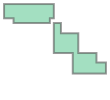

In [7]:
nom_zones = 'zones_dnv_shapes.pkl'
zones_dnv = pickle.load(open(nom_zones, "rb"))
zones_dnv = zones_dnv[zones_dnv.index != 'total']
cote_ouest = shapely.unary_union(zones_dnv.loc[['6', '7', '14','22','46','55'], 'polygone'])
cote_ouest

In [8]:
final_import_export = clean_columns(pd.read_excel(Path().cwd() / 'Documents' / 'LNG Tool Traité.xlsx')).set_index(['country', 'annee'])
final_import_export_part = final_import_export.reset_index().dropna(subset='part').set_index(['country', 'annee', 'part'])
final_import_export

5 column names have been cleaned

part  exportation  importation         type
country annee                                            
Alaska  2000   NaN         1.34          NaN  Exportateur
        2001   NaN         1.36          NaN  Exportateur
        2002   NaN         1.31          NaN  Exportateur
        2003   NaN         1.34          NaN  Exportateur
        2004   NaN         1.28          NaN  Exportateur
...            ...          ...          ...          ...
Brunei  2026   NaN          NaN          NaN  Exportateur
        2027   NaN          NaN          NaN  Exportateur
        2028   NaN          NaN          NaN  Exportateur
        2029   NaN          NaN          NaN  Exportateur
        2030   NaN          NaN          NaN  Exportateur

[3083 rows x 4 columns]

In [9]:
nom_locations = 'all_ports_locations.pkl'
df_geocodes = pickle.load(open(nom_locations, "rb"))
df_geocodes

,port,countryTerritory,port_clean,long_lat
0,Algiers,Algeria,Algiers,"(Alger ⴷⵣⴰⵢⴻⵔ الجزائر, Alger Centre ⴷⵣⴰⵢⴻⵔ ⵜⴰⵍ..."
1,Annaba,Algeria,Annaba,"(Annaba ⵄⴻⵍⵍⴰⴲⴰ عنابة, Daïra Annaba دائرة عناب..."
2,Arzew,Algeria,Arzew,"(Arzew ⴰⵔⴻⵣⵢⵓ أرزيو, Daïra Arzew, Oran ⵡⴻⵀⵔⴰⵏ ..."
3,Arzew El-Djedid,Algeria,Arzew,"(Arzew ⴰⵔⴻⵣⵢⵓ أرزيو, Daïra Arzew, Oran ⵡⴻⵀⵔⴰⵏ ..."
4,Mostaganem,Algeria,Mostaganem,"(Mostaganem ⵎⵓⵙⵜⵖⴰⵏⴻⵎ مستغانم, Algérie / ⵍⵣⵣⴰⵢ..."
...,...,...,...,...
532,FPSO 'Dai Hung 01',Vietnam,Vung Tau,"(Thành phố Vũng Tàu, Tỉnh Bà Rịa - Vũng Tàu, V..."
533,Vung Tau,Vietnam,Vung Tau,"(Thành phố Vũng Tàu, Tỉnh Bà Rịa - Vũng Tàu, V..."
534,Laayoune,Maroc,Laayoune,"(Laâyoune العيون, Pachalik de Laâyoune باشوية ..."
535,Balhaf LNG,Yemen,Balhaf,"(بلحاف, مديرية رضوم, محافظة شبوة, اليمن, (14.0..."


In [70]:
clean_port_calls_for_ctc = clean_port_calls.copy().merge(df_geocodes, on = ['port', 'port_clean', 'countryTerritory'], how='left')
clean_port_calls_for_ctc['annee'] = clean_port_calls_for_ctc.arrivalDate.apply(lambda arrDate: pd.to_datetime(arrDate).year)
clean_port_calls_for_ctc['long_lat'] = clean_port_calls_for_ctc.long_lat.apply(
    lambda point: shapely.Point(point.longitude, point.latitude)
)
clean_port_calls_for_ctc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146795 entries, 0 to 146794
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   port              146795 non-null  object        
 1   callingType       146795 non-null  object        
 2   countryTerritory  146795 non-null  object        
 3   arrivalDate       146795 non-null  datetime64[ns]
 4   arrivalDraught    128801 non-null  float64       
 5   departureDraught  128748 non-null  float64       
 6   navire            146795 non-null  object        
 7   port_clean        146783 non-null  object        
 8   long_lat          146795 non-null  object        
 9   annee             146795 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 12.3+ MB


In [71]:
def assign(row, export_import, export_import_part, cote_ouest):
    # print(export_import.loc[(row['countryTerritory'], row['annee']), 'part'])
    try:
        if pd.isnull(export_import.loc[(row['countryTerritory'], row['annee']), 'part']).values[0]:
            return export_import.loc[(row['countryTerritory'], row['annee']), 'type'].values[0]
        else:
            if row['long_lat'].within(cote_ouest):
                return export_import_part.loc[(row['countryTerritory'], row['annee'], 'West'), 'type']
            else:
                return export_import_part.loc[(row['countryTerritory'], row['annee'], 'East'), 'type']
    except KeyError:
        return 'escale'

In [72]:
clean_port_calls_for_ctc['importExport'] = clean_port_calls_for_ctc.progress_apply(
    lambda row: assign(row, final_import_export, final_import_export_part), axis=1
)

  0%|          | 0/146795 [00:00<?, ?it/s]

C:\Users\TRS\AppData\Local\Temp\ipykernel_16536\3743126056.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  if pd.isnull(export_import.loc[(row['countryTerritory'], row['annee']), 'part']).values[0]:
C:\Users\TRS\AppData\Local\Temp\ipykernel_16536\3743126056.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  return export_import.loc[(row['countryTerritory'], row['annee']), 'type'].values[0]


In [73]:
clean_port_calls_for_ctc['importExport'].value_counts()

Importateur    74532
Exportateur    57383
escale         14880
Name: importExport, dtype: int64

### Clean avec fonction

Ce qu'il faut faire : lire les port calls SANS supprimer les lignes sans ports ? regarder si ça change quelque chose
cleaner les noms si nécessaire
regarder où on a chargement et déchargement.
Supprimer les autres lignes
Appliquer le principe habituel pour avoir non pas un port mais un trajet par ligne avec chargement au début et déchargement à la fin AINSI QUE LES DATES

In [10]:
nom_zones = 'zones_dnv_shapes.pkl'
zones_dnv = pickle.load(open(nom_zones, "rb"))
zones_dnv = zones_dnv[zones_dnv.index != 'total']
cote_ouest = shapely.unary_union(zones_dnv.loc[['6', '7', '14', '22', '46', '55'], 'polygone'])
cote_ouest
final_import_export = clean_columns(pd.read_excel(Path().cwd() / 'Documents' / 'LNG Tool Traité.xlsx')).set_index(
    ['country', 'annee'])
final_import_export_part = final_import_export.reset_index().dropna(subset='part').set_index(
    ['country', 'annee', 'part'])
final_import_export
nom_locations = 'all_ports_locations.pkl'
df_geocodes = pickle.load(open(nom_locations, "rb"))
df_geocodes

5 column names have been cleaned

,port,countryTerritory,port_clean,long_lat
0,Algiers,Algeria,Algiers,"(Alger ⴷⵣⴰⵢⴻⵔ الجزائر, Alger Centre ⴷⵣⴰⵢⴻⵔ ⵜⴰⵍ..."
1,Annaba,Algeria,Annaba,"(Annaba ⵄⴻⵍⵍⴰⴲⴰ عنابة, Daïra Annaba دائرة عناب..."
2,Arzew,Algeria,Arzew,"(Arzew ⴰⵔⴻⵣⵢⵓ أرزيو, Daïra Arzew, Oran ⵡⴻⵀⵔⴰⵏ ..."
3,Arzew El-Djedid,Algeria,Arzew,"(Arzew ⴰⵔⴻⵣⵢⵓ أرزيو, Daïra Arzew, Oran ⵡⴻⵀⵔⴰⵏ ..."
4,Mostaganem,Algeria,Mostaganem,"(Mostaganem ⵎⵓⵙⵜⵖⴰⵏⴻⵎ مستغانم, Algérie / ⵍⵣⵣⴰⵢ..."
...,...,...,...,...
532,FPSO 'Dai Hung 01',Vietnam,Vung Tau,"(Thành phố Vũng Tàu, Tỉnh Bà Rịa - Vũng Tàu, V..."
533,Vung Tau,Vietnam,Vung Tau,"(Thành phố Vũng Tàu, Tỉnh Bà Rịa - Vũng Tàu, V..."
534,Laayoune,Maroc,Laayoune,"(Laâyoune العيون, Pachalik de Laâyoune باشوية ..."
535,Balhaf LNG,Yemen,Balhaf,"(بلحاف, مديرية رضوم, محافظة شبوة, اليمن, (14.0..."


In [26]:
reload(cr)
reload(pg)
navire = "YENISEI RIVER"
# date_livraison = pd.to_datetime("2010-05-28") # AAMIRA
date_livraison = pd.to_datetime("2013-07-01") # YENISEI
# date_livraison = pd.to_datetime("2006-12-06") # SERI ANGKASA
# date_livraison = pd.to_datetime("2014-06-10") # ASIA VISION
# date_livraison = pd.to_datetime("1997-11-13") # AMAN SENDAI
# date_livraison = pd.to_datetime("2018-03-20") # GASLOG HONG KONG
df = cr.retrieve_all_preprocessing_ctc_one_boat(
    Path().cwd() / 'Port Calls', f'{navire.upper()} Port Callings.xlsx', date_livraison,
    cote_ouest, final_import_export, final_import_export_part, df_geocodes,
    prints=False, port_calls=None, return_only_ctc=False
)

0it [00:00, ?it/s]

C:\Users\TRS\Documents\exploit-bdd-rex\0_utilitaires_et_globaux\classe_routes.py:778: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\TRS\Documents\exploit-bdd-rex\0_utilitaires_et_globaux\classe_routes.py:957: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



In [29]:
df[df.arrivalDate > "2018-01-01"]

,Navire,port,callingType,destination,clean_destination,destinationCountry,countryTerritory,arrivalDate,arrivalDraught,departureDraught,departureDate,port_clean,annee,LoadedDepart,LoadedArrival,aVide,dureeVoyage,TC,importExport,importExportArrival
707,YENISEI RIVER,Zhuhai,Terminal,Naoetsu,Naoetsu,Japan,China,2018-01-13 00:21:21,11.4,9.4,2017-12-22 08:20:28,Macao,2017,False,False,1.0,21.0,1.0,NaN,NaN
704,YENISEI RIVER,Naoetsu,Terminal,Dahej,Dahej,India,Japan,2018-03-09 07:44:51,11.5,9.4,2018-01-13 00:21:21,Naoetsu,2018,False,False,1.0,55.0,1.0,NaN,NaN
693,YENISEI RIVER,Dahej,Port,Point Fortin,Point Fortin,Trinidad & Tobago,India,2018-04-04 12:40:49,11.5,9.8,2018-03-10 05:53:50,Dahej,2018,False,True,1.0,25.0,1.0,NaN,NaN
689,YENISEI RIVER,Point Fortin,Terminal,Cartagena (Spain),Cartagena,Spain,Trinidad & Tobago,2018-04-16 06:40:50,9.3,11.3,2018-04-05 16:11:15,Point Fortin,2018,True,False,0.0,10.0,0.0,NaN,NaN
687,YENISEI RIVER,Cartagena (Spain),Terminal,Port Said,Port Said,Egypt,Spain,2018-05-20 10:55:50,11.2,9.6,2018-04-17 07:25:52,Cartagena,2018,False,True,1.0,33.0,1.0,NaN,NaN
677,YENISEI RIVER,Port Said,Anchorage,Bilbao,Bilbao,Spain,Egypt,2018-09-22 11:54:19,4.6,11.5,2018-05-20 10:55:50,Port Said,2018,True,False,0.0,125.0,0.0,NaN,NaN
663,YENISEI RIVER,Bilbao,Port,Bonny Inshore Terminal,Bonny,Nigeria,Spain,2018-12-03 11:55:18,11.3,9.3,2018-09-23 12:24:19,Bilbao,2018,False,True,1.0,70.0,1.0,NaN,NaN
656,YENISEI RIVER,Bonny Inshore Terminal,Terminal,Dalian,"Dalian, Liaoning",China,Nigeria,2019-01-08 06:55:18,9.2,11.5,2018-12-05 12:40:18,Bonny,2018,True,False,0.0,33.0,0.0,NaN,NaN
652,YENISEI RIVER,Dalian,Terminal,Nantes-St Nazaire,Nantes-St Nazaire,France,China,2019-02-13 20:53:28,11.3,9.3,2019-01-09 23:00:27,"Dalian, Liaoning",2019,False,True,1.0,34.0,1.0,NaN,NaN
645,YENISEI RIVER,Nantes-St Nazaire,Terminal,Revithoussa Terminal,Revythousa,Greece,France,2019-02-24 08:40:16,9.3,11.5,2019-02-16 01:25:15,Nantes-St Nazaire,2019,True,False,0.0,8.0,0.0,NaN,NaN


In [15]:
df.to_excel('yenisei_perso.xlsx')

## Travail Précédent

### Villes avec "Terminal"

In [ ]:
terminals = clean_port_calls[
    (clean_port_calls.callingType=='Terminal')
][['port_clean', 'countryTerritory']].drop_duplicates()
terminals.to_clipboard()
terminals

In [ ]:
navire = "AMANI"
date_livraison = pd.to_datetime("2014-11-13")
navire_calls = clean_columns(pd.read_excel(Path().cwd().parent / '1_Input_Routes'/ 'Port Calls' / f'{navire.upper()} Port Callings.xlsx', usecols='A:F'), 'camel')
navire_calls = cr.clean_port_names(navire_calls.sort_values(by = 'arrivalDate').reset_index(drop=True))
navire_calls.arrivalDate = pd.to_datetime(navire_calls.arrivalDate)
navire_calls = navire_calls[navire_calls.arrivalDate >= date_livraison + pd.Timedelta(1, unit='d')]
navire_calls.insert(0, 'navire', navire)
navire_calls['isTerminal'] = navire_calls.port_clean.apply(lambda x : x in terminals.port_clean.to_list())
navire_calls = navire_calls[~navire_calls.callingType.str.contains('Anchor')]
navire_calls

In [ ]:
navire_calls.isTerminal.value_counts()

### Récupération de la date où tout devient propre --> Not Working

In [ ]:
basic_port_calls = clean_columns(pd.concat(port_calls_all, axis=0), case='camel')
basic_port_calls[basic_port_calls.port.isnull()]

In [ ]:
checks_date_tonage = pd.Series(basic_port_calls.navire.unique(), name="nomNavire").to_frame()
checks_date_tonage['min_date'] = checks_date_tonage.nomNavire.apply(lambda nom: basic_port_calls[(basic_port_calls.navire==nom)&(basic_port_calls.arrivalDraught.isnull())].arrivalDate.dropna().max())
checks_date_tonage.min_date.hist()

--> Date où tout est propre : 2013-06-01

In [ ]:
reload(pg)
pg.DATE_DRAUGHT

In [ ]:
navire = "AMANI"
navire_calls = clean_columns(pd.read_excel(Path().cwd().parent / '1_Input_Routes'/ 'Port Calls' / f'{navire.upper()} Port Callings.xlsx', usecols='A:F'), 'camel')
navire_calls = cr.clean_port_names(navire_calls.sort_values(by = 'arrivalDate').reset_index(drop=True))
navire_calls.insert(0, 'navire', navire)
idx_last_non_clean = navire_calls[navire_calls.arrivalDraught.isnull()].index.max()
if str(idx_last_non_clean)=="nan":
    idx_last_non_clean = -1
print(idx_last_non_clean)
navire_calls_clean = navire_calls.loc[idx_last_non_clean + 1:, :]
navire_calls_clean.arrivalDate = navire_calls_clean.arrivalDate.apply(lambda dat : dat.strftime('%Y-%m-%d'))
navire_calls_clean = navire_calls_clean[~navire_calls_clean.callingType.str.contains('Anchorage')].copy()
navire_calls_clean.to_clipboard()

In [ ]:
navire_calls_clean_terminals = navire_calls_clean[
    (navire_calls_clean.arrivalDraught - navire_calls_clean.departureDraught).apply(np.abs)>0
].copy()
navire_calls_clean_terminals.dropna(subset=['port', 'arrivalDate', 'departureDraught'], inplace=True)
navire_calls_clean_terminals.insert(4, "destination", navire_calls_clean_terminals.port.shift(-1))
navire_calls_clean_terminals.insert(5, "destinationCountry", navire_calls_clean_terminals.countryTerritory.shift(-1))
# Dates d'un trajet : departure date of 1st port -> arrival date of second port
navire_calls_clean_terminals['arrivalDate'] = navire_calls_clean_terminals["arrivalDate"].shift(-1)
navire_calls_clean_terminals['finalDraught'] = navire_calls_clean_terminals['departureDraught'].shift(-1)
navire_calls_clean_terminals.drop(columns = ['arrivalDraught', 'callingType'], inplace=True)
navire_calls_clean_terminals = navire_calls_clean_terminals[~navire_calls_clean_terminals.destination.isnull()]
navire_calls_clean_terminals[[
    "navire",
    "port",
    "port_clean",
    "countryTerritory",
    "destination",
    "destinationCountry",
    'arrivalDate',
    "departureDraught",
    "finalDraught"
]]